# Comparing encroachment and interaction matrix measure

In [1]:
import torch
import numpy as np
import math

from Functions import SampleSimplex, Jacobian, IntMatrix, Inew, Heteros

In [2]:
Nr = 32
Ns = 16
num_rho = 512

num_comp = 4
comp_span = torch.tensor([1.0,0.8,0.6,0.4])

rho_span = torch.zeros(num_rho)
rho_span[:int(num_rho/2)] = torch.linspace(0, .869, steps=int(num_rho/2))
rho_span[int(num_rho/2):] = torch.linspace(.87, 1, steps=int(num_rho/2))

outputs = torch.zeros(num_comp,num_rho,4)
GGdiss_mean = torch.zeros(4)
for i in range(num_comp):
    comp = comp_span[i]
    for j in range(num_rho):
        rho = rho_span[j]
        G,C,Ss,_ = SampleSimplex(Ns, Nr, rho, comp)
        GGdiss_mean[i] += torch.mean(Heteros(G))
        outputs[i,j,0] = Jacobian(G,C,Ss)
        
        mean, sigma, _ = IntMatrix(G,C,Ss)
        outputs[i,j,1] = sigma * math.sqrt(Ns) + mean

        #Gnew = (G - torch.ones(Ns,Nr)/Nr)/comp + torch.ones(Ns,Nr)/Nr
        #Cnew = (C - torch.ones(Ns,Nr)/Nr)/comp + torch.ones(Ns,Nr)/Nr
        Imean, Istd = Inew(G,C)
        outputs[i,j,2] = Imean
        outputs[i,j,3] = Istd
        
GGdiss_mean = GGdiss_mean/num_rho

In [3]:
unstable = (outputs[:,:,0] > 0).float()

In [4]:
figout = {'intm0':[], 'intm1':[], 'intm2':[], 'intm3':[],
          'E0':[], 'E1':[], 'E2':[], 'E3':[]}

In [5]:
"""
intm_mean = []
uf_mean = []
intm_std = []
uf_std = []
"""
for ii in range(4):
    intm = torch.tensor([])
    if ii <= 1:
        gridwidth = 0.025
    else:
        gridwidth = 0.008

    for i in range(100):
        indeces = ((i*gridwidth+1.0 <=outputs[ii,:,1]) & (outputs[ii,:,1]<(i+1)*gridwidth+1.0)).nonzero(as_tuple=True)
        x_group = (outputs[ii,:,1])[indeces]
        y_group = unstable[ii][indeces]
        if x_group.size() != torch.Size([0]):
            intm = torch.cat((intm,
                    torch.tensor([torch.mean(x_group), torch.std(x_group)/math.sqrt(len(x_group)), 
                                    torch.mean(y_group), torch.std(y_group)/math.sqrt(len(y_group))]).unsqueeze(0)),0)
            
    Es = torch.tensor([])
    for i in range(60):
        indeces = ((i*0.1<=outputs[ii,:,2]) & (outputs[ii,:,2]<(i+1)*0.1)).nonzero(as_tuple=True)
        x_group = (outputs[ii,:,2])[indeces]
        y_group = unstable[ii][indeces]
        z_group = (outputs[ii,:,0])[indeces]
        if x_group.size() != torch.Size([0]):
            Es = torch.cat((Es,
                    torch.tensor([torch.mean(x_group), torch.std(x_group)/math.sqrt(len(x_group)), 
                                    torch.mean(y_group), torch.std(y_group)/math.sqrt(len(y_group)),
                                    torch.mean(z_group), torch.std(z_group)/math.sqrt(len(z_group))]).unsqueeze(0)),0)
            
    intm = torch.nan_to_num(intm)
    Es = torch.nan_to_num(Es)
    figout['intm'+str(ii)].append(intm)
    figout['E'+str(ii)].append(Es)

In [6]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 11})

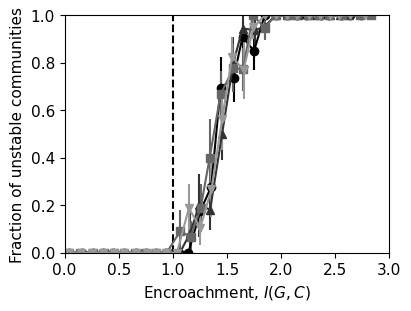

In [10]:
plt.figure(figsize=(4, 3), constrained_layout=True)
makers = ['o','^','s','v']
colors = ['0', '0.2', '0.4', '.6']

for ii in range(4):
    plt.errorbar(figout['E'+str(ii)][0][:,0],figout['E'+str(ii)][0][:,2],
                 xerr=figout['E'+str(ii)][0][:,1], yerr= figout['E'+str(ii)][0][:,3],lw=1.5,marker=makers[ii], color = colors[ii]) # ls = 'none'
    
#plt.legend(['Generality 1','Generality 2','Generality 3','Generality 4'])
plt.plot(torch.linspace(1.,1.,steps=10),torch.linspace(0.,1.,steps=10), 'k--')
plt.xlim(0.0,3.0)
plt.ylim(0.,1.0)
plt.xlabel('Encroachment, $I(G,C)$')
plt.ylabel('Fraction of unstable communities')
plt.savefig('../../figures/Figure2emb1v1.eps',format='eps')

Text(0, 0.5, 'Fraction of unstable modes')

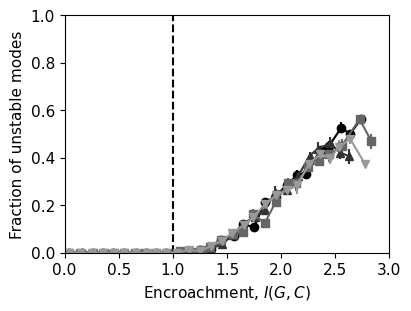

In [11]:
plt.figure(figsize=(4, 3), constrained_layout=True)
makers = ['o','^','s','v']
colors = ['0', '0.2', '0.4', '.6']

for ii in range(4):
    plt.errorbar(figout['E'+str(ii)][0][:,0],figout['E'+str(ii)][0][:,4],
                 xerr=figout['E'+str(ii)][0][:,1], yerr= figout['E'+str(ii)][0][:,5],lw=1.5,marker=makers[ii], color = colors[ii]) # ls = 'none'
    
#plt.legend(['Generality 1','Generality 2','Generality 3','Generality 4'])
plt.plot(torch.linspace(1.,1.,steps=10),torch.linspace(0.,1.,steps=10), 'k--')
plt.xlim(0.0,3.0)
plt.ylim(0.,1.0)
plt.xlabel('Encroachment, $I(G,C)$')
plt.ylabel('Fraction of unstable modes')

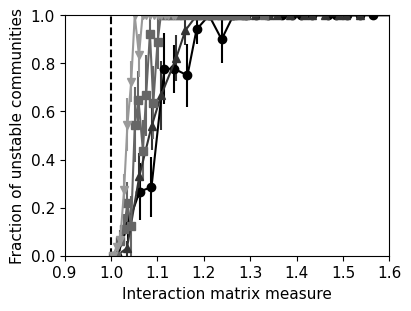

In [12]:
plt.figure(figsize=(4, 3), constrained_layout=True)
makers = ['o','^','s','v']
colors = ['0', '0.2', '0.4', '.6']

for ii in range(4):
    plt.errorbar(figout['intm'+str(ii)][0][:,0],figout['intm'+str(ii)][0][:,2], 
                 xerr=figout['intm'+str(ii)][0][:,1], yerr= figout['intm'+str(ii)][0][:,3],lw=1.5,marker=makers[ii], color = colors[ii])

#plt.legend(['Generality 1','Generality 2','Generality 3','Generality 4'])
plt.plot(torch.linspace(1.,1.,steps=10),torch.linspace(0.,1.,steps=10), 'k--')
plt.xlim(0.9,1.6)
plt.ylim(0.,1.0)
plt.xlabel('Interaction matrix measure')
plt.ylabel('Fraction of unstable communities')
plt.savefig('../../figures/Figure2emb2v1.eps',format='eps')